# TensorFlow RBM Model with Mean Field Method

**Description:** Implementation of a Restricted Boltzmann Machine (RBM) with the Mean Field method in TensorFlow.

**Author:** Kevin Juan Román Rafaele

**Date:** 2024-07-23

**License:** MIT License

**GitHub:** https://github.com/PoppinElo/meanFieldRBM-TF


# Restricted Boltzmann Machine Implementation with Mean Field Theory

This notebook implements a Restricted Boltzmann Machine (RBM) using the Mean Field method in TensorFlow. The RBM is a type of stochastic neural network that can learn a probability distribution over its set of inputs. The Mean Field method approximates the intractable computations involved in the RBM learning process.

## Requirements
- TensorFlow 2.x
- numpy
- matplotlib

## Usage
Run each cell sequentially to execute the code and visualize the results.

## Sections
1. Import Libraries
2. Define RBM Class
3. Train RBM
4. Visualize Results



In [ ]:
# Import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## What is an RBM?

An RBM consists of two layers:

*   Visible Layer: This layer represents the input data.
*   Hidden Layer: This layer captures complex patterns in the data by learning a probabilistic distribution.

Each visible unit is connected to all hidden units, but there are no connections between units within the same layer. This restriction simplifies the learning process and makes RBMs more efficient to train compared to general Boltzmann machines.

## Learning with Contrastive Divergence

The learning process of an RBM involves the following steps:

*   Positive Phase: The model computes the probabilities of the hidden units being active given the observed data.
*   Negative Phase: The model reconstructs the visible units from the hidden units and then re-estimates the hidden units.
*   Parameter Update: The difference between the data-driven and model-driven associations is used to update the weights and biases.

This method, called Contrastive Divergence (CD), approximates the gradient of the log-likelihood of the data, making the learning process efficient.

## Mean Field Theory in RBM

Mean Field Theory (MFT) is a mathematical approach used to approximate complex probabilistic models by simplifying the interactions between variables. In the context of RBMs, MFT is used to approximate the marginal distributions of the hidden units, which allows for a more efficient and accurate estimation of the model parameters during training.

By integrating MFT into the contrastive divergence learning process, we improve the estimation of hidden unit probabilities. Instead of sampling stochastic binary states for the hidden units, MFT uses continuous probabilities as deterministic real values states, which provides a smoother and more reliable update for the model parameters.

In [ ]:
# Define the RBM class
class RBM(tf.keras.Model):
    def __init__(self, num_visible, num_hidden):
        super(RBM, self).__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.W = tf.Variable(tf.random.normal([num_visible, num_hidden], stddev=0.1, dtype=tf.float64), name='weights')
        self.visible_bias = tf.Variable(tf.zeros([num_visible], dtype=tf.float64), name='visible_bias')
        self.hidden_bias = tf.Variable(tf.zeros([num_hidden], dtype=tf.float64), name='hidden_bias')

    def call(self, inputs):
        hidden_prob = tf.nn.sigmoid(tf.matmul(inputs, self.W) + self.hidden_bias)
        return hidden_prob

    # Hidden Units activation function, return the activation probabilities and the states binary values
    def sample_hidden(self, visible):
        hidden_prob = tf.nn.sigmoid(tf.matmul(visible, self.W) + self.hidden_bias)
        hidden_state = tf.nn.relu(tf.sign(hidden_prob - tf.random.uniform(tf.shape(hidden_prob), dtype=tf.float64)))
        return hidden_prob, hidden_state

    # Visible Units activation function, return the activation probabilities and the states binary values
    def sample_visible(self, hidden):
        visible_prob = tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(self.W)) + self.visible_bias)
        visible_state = tf.nn.relu(tf.sign(visible_prob - tf.random.uniform(tf.shape(visible_prob), dtype=tf.float64)))
        return visible_prob, visible_state

    # Constrastive Divergence function for parameters updating
    def contrastive_divergence(self, v0, lr=0.1, k=1, mean_field = True):
        # Using Mean Field Method
        if(mean_field):
            # Positive phase
            h0 = self.sample_hidden(v0)[0]
            # Negative phase
            for i in range(k):
                v1 = self.sample_visible(h0)[0]
                h1 = self.sample_hidden(v1)[0]
        # Traditional Contrastive Divergence
        else:
            # Positive phase
            h0 = self.sample_hidden(v0)[1]
            # Negative phase
            for i in range(k):
                v1 = self.sample_visible(h0)[1]
                h1 = self.sample_hidden(v1)[1]
        # Compute gradients
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        # Update parameters
        batch_size = tf.cast(tf.shape(v0)[0], tf.float64)
        delta_W = lr * (positive_grad - negative_grad) / batch_size
        delta_visible_bias = lr * tf.reduce_mean(v0 - v1, axis=0)
        delta_hidden_bias = lr * tf.reduce_mean(h0 - h1, axis=0)
        self.W.assign_add(delta_W) # Update the correlation weights
        self.visible_bias.assign_add(delta_visible_bias) # Update the visible biases
        self.hidden_bias.assign_add(delta_hidden_bias) # Update the hidden biases

    # Reconstruction error function, compares input images with their respective reconstructed images
    def reconstruction_error(self, v0, v1):
        return tf.reduce_mean(tf.square(v0 - v1))

    # Internal energy function, recreates the approximated expected value of the RBM energy over the dataset
    def internal_energy(self, v0):
        h0 = self.sample_hidden(v0)[1]
        # Enery terms
        vWh = tf.reduce_sum(tf.matmul(v0, self.W) * h0, axis=1) # Correlation term
        vb = tf.reduce_sum(v0 * self.visible_bias, axis=1) # Only visible term
        hb = tf.reduce_sum(h0 * self.hidden_bias, axis=1) # Only hidden term
        # Total Internal Energy
        U = -(tf.reduce_mean(vWh) + tf.reduce_mean(vb) + tf.reduce_mean(hb))
        return U

## Data Preprocessing

The MNIST dataset is loaded and preprocessed by normalizing the pixel values and reshaping the images into vectors.



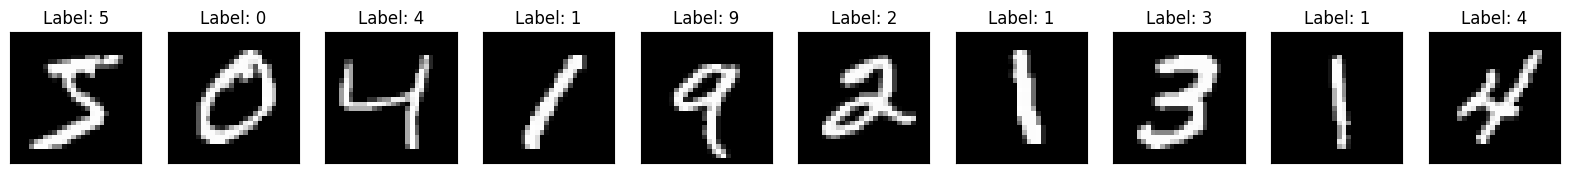

In [ ]:
# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = tf.reshape(x_train, (len(x_train), -1)).numpy()
x_test = tf.reshape(x_test, (len(x_test), -1)).numpy()

# Visualize data
n_samples = 10
sample_data = x_train[:n_samples]

plt.figure(figsize=(20, 4))
for i in range(n_samples):
    # Sample
    plt.subplot(2, n_samples, i + 1)
    plt.imshow(sample_data[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.xticks([])
    plt.yticks([])

## Training Loop

The training loop iterates over the dataset for a specified number of epochs, performing contrastive divergence with Mean Field Theory and calculating the reconstruction error to track the learning progress.

In [ ]:
# Initialize RBM
num_visible = x_train.shape[1]
num_hidden = 128
rbm = RBM(num_visible, num_hidden)

In [ ]:
# Training loop
epochs = 50
batch_size = 64
learning_rate = 0.1
k = 1  # Contrastive Divergence steps
MFT = True  # Mean Field Method activation

reconstruction_errors = []
internal_energies = []

for epoch in range(epochs):
    np.random.shuffle(x_train)
    for i in range(0, len(x_train), batch_size):
        batch_data = x_train[i:i+batch_size]
        rbm.contrastive_divergence(batch_data, lr=learning_rate, k=k, mean_field = MFT)

    # Calculate reconstruction error
    if( MFT ):
        reconstructed_data = rbm.sample_visible(rbm.sample_hidden(x_train)[1])[1].numpy()
    else:
        reconstructed_data = rbm.sample_visible(rbm.sample_hidden(x_train)[0])[0].numpy()
    error = rbm.reconstruction_error(x_train, reconstructed_data).numpy(), rbm.internal_energy(x_train).numpy()
    reconstruction_errors.append(error[0])
    internal_energies.append(error[1])

    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Reconstruction Error: {error[0]}, Internal Energy: {error[1]}")

Epoch 1/50, Reconstruction Error: 0.06249213384602206, Internal Energy: -184.40553504453715
Epoch 11/50, Reconstruction Error: 0.04385455748214318, Internal Energy: -371.18925400872246
Epoch 21/50, Reconstruction Error: 0.04166483275892056, Internal Energy: -396.5990168325214
Epoch 31/50, Reconstruction Error: 0.040693530237912154, Internal Energy: -402.4875765437075
Epoch 41/50, Reconstruction Error: 0.04017759094552854, Internal Energy: -403.67225028715853


## Visualization

The code includes several visualizations:

*   Learned Features: Display the weights of the hidden units as images.
*   Original vs Reconstructed Data: Compare the original input images with their reconstructions from the RBM.
*   Reconstruction Error: Plot the reconstruction error over epochs to visualize the learning process.

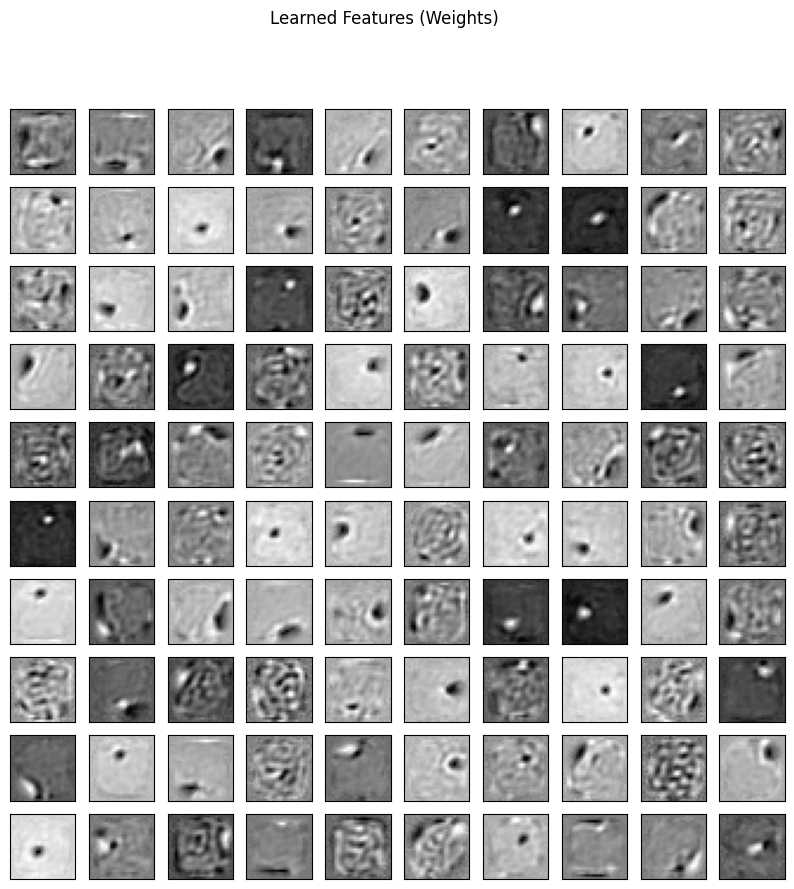

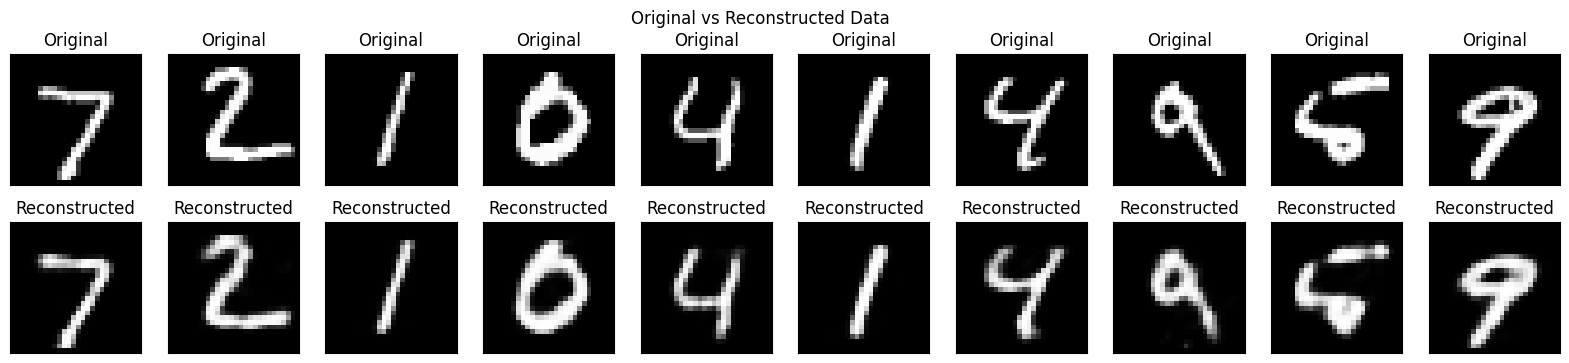

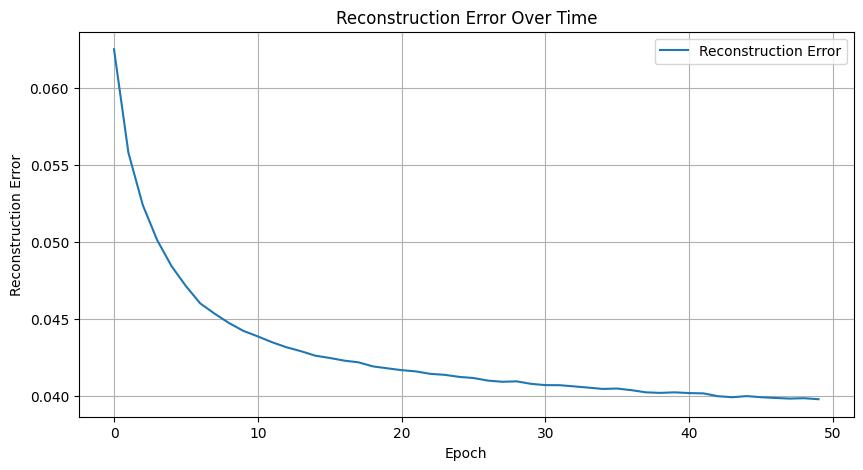

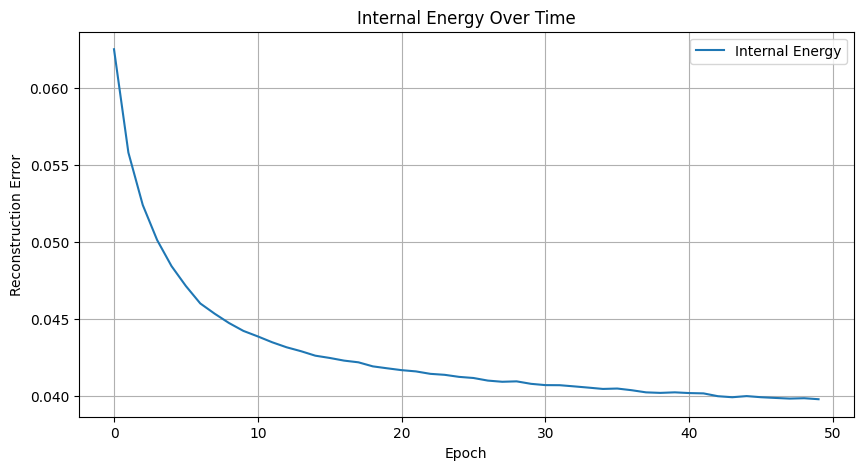

In [ ]:
# Visualization
# 1. Visualize learned features (weights)
weights = rbm.W.numpy().T
plt.figure(figsize=(10, 10))
for i, comp in enumerate(weights[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.suptitle('Learned Features (Weights)')
plt.show()

# 2. Visualize original data and reconstructions
n_samples = 10
original_data = x_test[:n_samples]
if(MFT):
    reconstructed_data = rbm.sample_visible(rbm.sample_hidden(original_data)[0])[0].numpy()
else:
    reconstructed_data = rbm.sample_visible(rbm.sample_hidden(original_data)[1])[1].numpy()

plt.figure(figsize=(20, 4))
for i in range(n_samples):
    # Original
    plt.subplot(2, n_samples, i + 1)
    plt.imshow(original_data[i].reshape(28, 28), cmap='gray')
    plt.title('Original')
    plt.xticks([])
    plt.yticks([])

    # Reconstruction
    plt.subplot(2, n_samples, i + 1 + n_samples)
    plt.imshow(reconstructed_data[i].reshape(28, 28), cmap='gray')
    plt.title('Reconstructed')
    plt.xticks([])
    plt.yticks([])

plt.suptitle('Original vs Reconstructed Data')
plt.show()

# 3. Visualize reconstruction error
plt.figure(figsize=(10, 5))
plt.plot(reconstruction_errors, label='Reconstruction Error')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.title('Reconstruction Error Over Time')
plt.grid(True)
plt.show()

# 4. Visualize internal energy values
plt.figure(figsize=(10, 5))
plt.plot(reconstruction_errors, label='Internal Energy')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.title('Internal Energy Over Time')
plt.grid(True)
plt.show()